In [7]:
# Import necessary libraries
import sys
sys.path.insert(0, '../')

import numpy as np
import torch as th
import gymnasium as gym
import matplotlib.pyplot as plt

from utils import get_state_dist, F_not_i, tqdm_label, get_pi_C, get_global_dist, process_shapley_values
from characteristics import Characteristics
from shapley import Shapley

from stable_baselines3 import DQN

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize

In [8]:
# Set the plotting parameters
from pylab import rcParams

params = { 
    'axes.labelsize': 22, 
    'font.size': 18, 
    'legend.fontsize': 12, 
    'xtick.labelsize': 16, 
    'ytick.labelsize': 16,
    "font.family" : "Times New Roman",
    "ytick.color" : "black",
    "xtick.color" : "black",
    "axes.labelcolor" : "black",
    "axes.edgecolor" : "black",
    'figure.figsize': [10, 8]
}
rcParams.update(params)

In [9]:
# Set the random seed for reproducibility
seed = 1234
np.random.seed(seed)
th.manual_seed(seed)

In [12]:
# Set the device
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")

# Create the environment
vec_env = make_vec_env(lambda: gym.make("CartPole-v1"), n_envs=1)

# Load the pre-trained model
model = A2C.load("../model/cartpole_a2c", device=device)

# Sample the state distribution
state_dist = get_state_dist(model=model, vec_env=vec_env, sample_size=1e5)

# For computing global shapley value:
global_dist = get_global_dist(state_dist=state_dist, sample_size=1000)
states_to_explain = th.tensor(tuple(global_dist.keys()),device=device).squeeze(1)

# Get the conditional policy on masked states
# Note: F_not_i is the function that masks out the i-th feature
pi_Cs = {tuple(C): get_pi_C(env=vec_env, model=model, C=C, state_dist=state_dist, states_to_explain=states_to_explain) for C in tqdm_label(F_not_i(np.arange(vec_env.observation_space.shape[0])), 'Calculating all pi_C')}

# Get the on-policy characteristics function
characteristics = Characteristics(env=vec_env, states_to_explain=states_to_explain)
shapley_on_policy_characteristics = characteristics.shapley_on_policy(pi_Cs=pi_Cs, multi_process=False, num_p=1) # not checked yet, but running

# Compute the Shapley values
shapley = Shapley(states_to_explain)
shapley_value = shapley.run(shapley_on_policy_characteristics)

result = process_shapley_values(shapley_value, model)

/home/peilang/environment/rlc2025/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
Calculating Shapley values: 100%|██████████| 1000/1000 [00:01<00:00, 870.51it/s]


In [13]:
# Prepare the data for further analysis
one_shapley = result['shapley_value'][0]
two_shapley = result['shapley_value'][1]
three_shapley = result['shapley_value'][2]
four_shapley = result['shapley_value'][3]

one_obs = result['obs_value'][0]
two_obs = result['obs_value'][1]
three_obs = result['obs_value'][2]
four_obs = result['obs_value'][3]

colors = result['colors']

### Using KMeans Clusters and SVM for identifying boundary points

In [14]:
from sklearn.cluster import KMeans

# Combine the Shapley values into a single list for clustering
shapley_point = []
for i in range(len(one_shapley)):
    shapley_point.append([one_shapley[i], two_shapley[i], three_shapley[i], four_shapley[i]])

# Convert to NumPy array for easier manipulation
shapley_point = np.array(shapley_point)
kmeans = KMeans(n_clusters=2, random_state=seed, n_init="auto").fit(shapley_point)

Estimated number of clusters: 2
Estimated number of noise points: 0


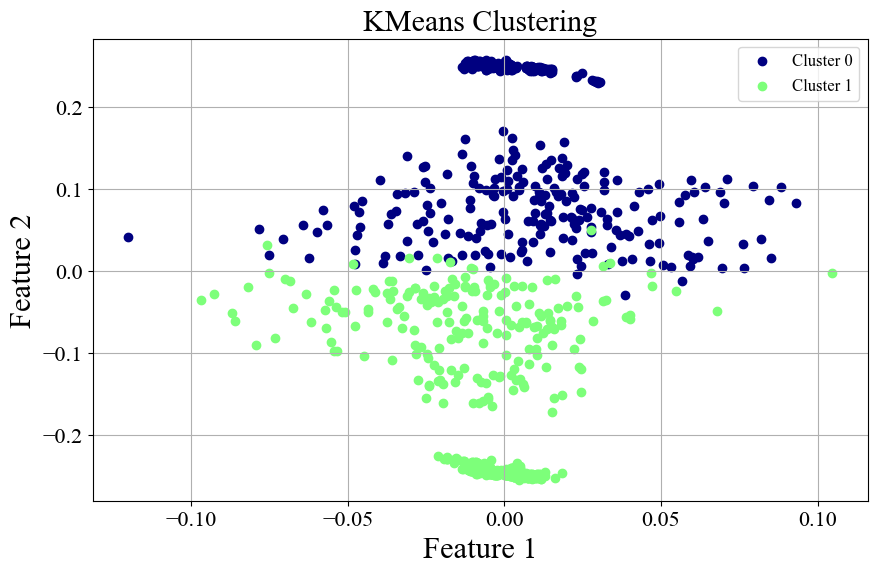

In [15]:
labels = kmeans.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Unique labels
unique_labels = set(labels)
unique_labels
# Plot each cluster with a different color
for label in unique_labels:
    if label == -1:
        # Noise points are marked in black
        color = 'r'
    else:
        color = plt.cm.jet(float(label) / len(unique_labels))  # Color map for clusters
    plt.scatter(shapley_point[labels == label, 0], 
                shapley_point[labels == label, 1], 
                color=color, 
                label=f'Cluster {label}' if label != -1 else 'Noise')

plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()


In [16]:
from sklearn import svm

clf = svm.SVC(kernel='linear', random_state=seed)
clf.fit(shapley_point, labels)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


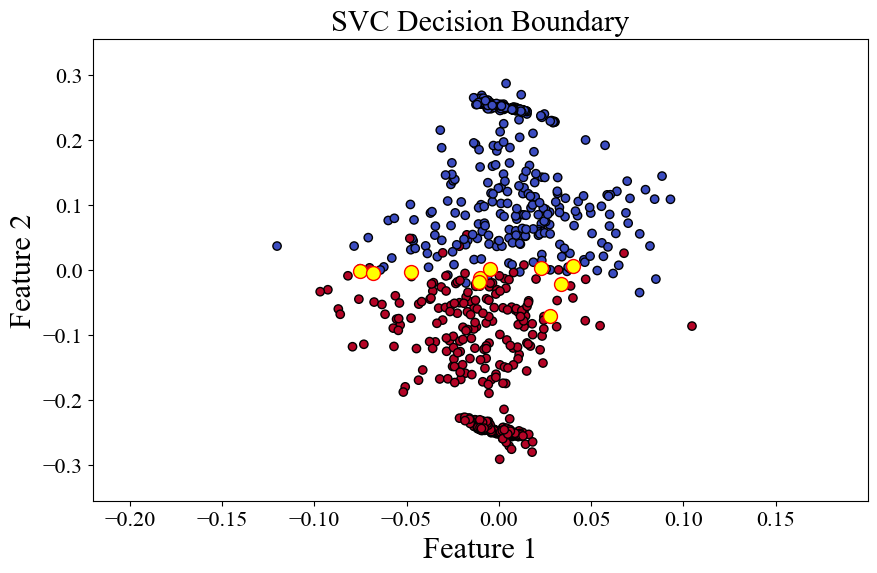

In [17]:
# Create a mesh grid for plotting
x_min, x_max = shapley_point[:, 0].min() - 0.1, shapley_point[:, 0].max() + 0.1
y_min, y_max = shapley_point[:, 1].min() - 0.1, shapley_point[:, 1].max() + 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))


# Find the indices of the 10 points closest to the decision boundary (smallest absolute decision values)
point_number = 10 # Number of closest points to find
decision_values = clf.decision_function(shapley_point)
closest_indices = np.argsort(np.abs(decision_values))[:point_number]

# Get the 10 closest points and their labels
closest_points = shapley_point[closest_indices]
closest_labels = labels[closest_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(shapley_point[:, 0], shapley_point[:, 3], c=labels, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)

# Highlight the 10 closest points to the decision boundary
plt.scatter(closest_points[:, 0], closest_points[:, 3], c='yellow', edgecolor='red', s=100, label='Closest points')

plt.title('SVC Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


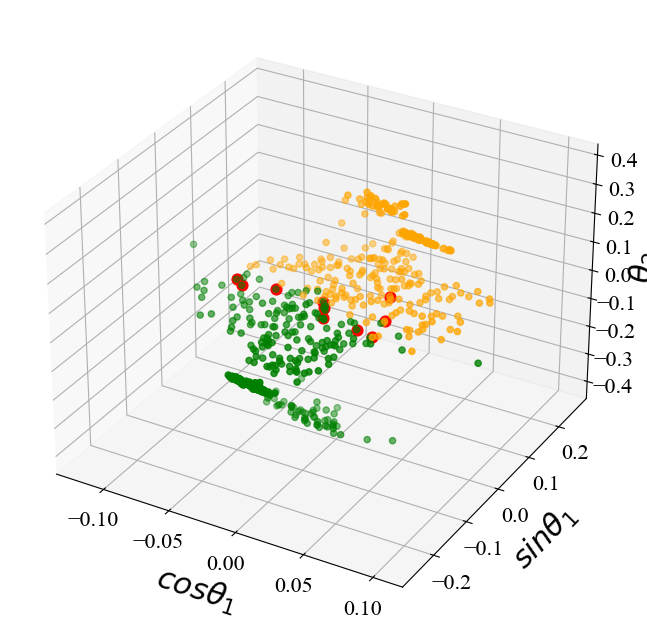

In [18]:
# Create figure with 3D projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Create scatter plot
scatter = ax.scatter(one_shapley, two_shapley, three_shapley, c=colors)

for i in closest_indices:
    ax.scatter(one_shapley[i], two_shapley[i], three_shapley[i], s=60, color='red')

# Label axes
ax.zaxis.labelpad=-0.2 

ax.set_xlabel(r'$cos\theta_1$')
ax.xaxis.labelpad=+10 

ax.set_ylabel(r'$sin\theta_1$')
ax.yaxis.labelpad=+10 

ax.set_zlabel(r'$\theta_2$', rotation=1800)  
ax.zaxis.labelpad=+2 

# Change the viewing angle if you want
# ax.view_init(elev=45, azim=90)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


data = []
for i in closest_indices:
    data.append([one_obs[i], two_obs[i], three_obs[i], four_obs[i]])
# Convert to numpy array
data = np.array(data)

# Separate features (X) and target variable (y)
X = data[:, :-1]  # All columns except the last
y = data[:, -1]   # Last column

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Regression function
def regression_function(x1, x2, x3, x4, x5):
    """
    Predicts target based on 3 input features
    Equation: y = b0 + b1*x1 + b2*x2 + b3*x3
    """
    return (model.intercept_ + 
            model.coef_[0] * x1 + 
            model.coef_[1] * x2 + 
            model.coef_[2] * x3)

# Print regression details
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Regression Function: y = {:.4f} + {:.4f}*x1 + {:.4f}*x2 + {:.4f}*x3".format(
    model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2]
))
print("R² Score:", r2_score(y, model.predict(X)))
print("Mean Squared Error:", mean_squared_error(y, model.predict(X)))


Coefficients: [-0.07279762 -1.13491602  0.        ]
Intercept: -0.009166908952653596
Regression Function: y = -0.0092 + -0.0728*x1 + -1.1349*x2 + 0.0000*x3
R² Score: 0.9998363735946625
Mean Squared Error: 1.1797463824838456e-07


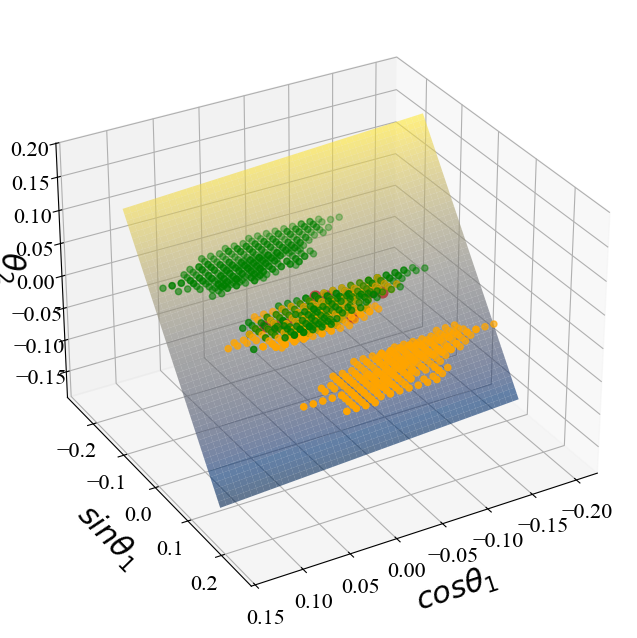

In [20]:
###### import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

data = []
for i in closest_indices:
    data.append([one_obs[i], two_obs[i], three_obs[i]])

# Convert to numpy array
data = np.array(data)
X = data[:, :2]  # X and Y coordinates
y = data[:, 2]   # W coordinates

# Create a mesh grid for plotting
x_range = np.linspace(min(data[:, 0]) - 0.1, max(data[:, 0]) + 0.1, 50)
y_range = np.linspace(min(data[:, 1]) - 0.1, max(data[:, 1]) + 0.1, 50)
X_mesh, Y_mesh = np.meshgrid(x_range, y_range)
W_mesh = model.intercept_ + model.coef_[0] * X_mesh + model.coef_[1] * Y_mesh


# Create figure with 3D projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Plot the regression plane
surf = ax.plot_surface(X_mesh, Y_mesh, W_mesh, alpha=0.6, cmap='cividis')


# Create scatter plot
scatter = ax.scatter(one_obs, two_obs, three_obs, c=colors)

for i in closest_indices:
    ax.scatter(one_obs[i], two_obs[i], three_obs[i], s=60, color='red')

# Label axes
ax.set_xlabel(r'$cos\theta_1$')
ax.xaxis.labelpad = +10 

ax.set_ylabel(r'$sin\theta_1$')
ax.yaxis.labelpad = +10 

ax.set_zlabel(r'$\theta_2$', rotation=1800) 
ax.zaxis.labelpad = +2 # <- change the value here

# Change the viewing angle if you want
ax.view_init(elev=30, azim=60)